In [1]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.cross_decomposition import PLSCanonical

In [173]:
data = pd.read_csv('study_266_processed.csv', index_col=0, dtype={'Disease': str})

In [174]:
feature_data = data.T[['npeaks','pcgroup','drt']].T.drop('Disease', axis=1)
data_d = data.T.drop(labels=['npeaks','pcgroup', 'drt'], axis=1).T

In [175]:
(X,y) = (data_d.drop('Disease', axis=1), data_d['Disease'])
dummies=pd.get_dummies(y)
y = dummies.iloc[:,0].values

In [176]:
feature_scaler = StandardScaler()
feature_data_scaled = feature_scaler.fit_transform(feature_data.T[['npeaks','drt']])
feature_data.T[['npeaks', 'drt']] = feature_data_scaled 

In [177]:
from sklearn.cross_validation import train_test_split

In [178]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

In [179]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_data, npeaks=0, drt=0, group=False, log_scale=False):
        self.npeaks = npeaks
        self.drt = drt
        self.group = group
        self.feature_data = feature_data
        self.log_scale = log_scale
        
    def fit(self, x, y = None):
        return self
    
    def transform(self, data):
        if self.log_scale:
            data = data.fillna(1).replace(0,1).apply(np.log10)
        else:
            data = data.fillna(0)
        data = data.astype(float)
        data = pd.concat([data,feature_data], axis=0)
        data = data.T
        index_to_drop=[]
        for index,row in data.iterrows():
            npeaks_data = row['npeaks']
            drt_data = row['drt']
            if npeaks_data<self.npeaks or drt_data<self.drt:
                index_to_drop.append(index)
        data = data.drop(index_to_drop).drop(['npeaks','drt'], axis=1)
        if self.group:
            data = data.astype(float).groupby('pcgroup').mean().T.values
        else:
            data = data.astype(float).drop('pcgroup', axis=1).T.values
        return data

In [180]:
feature_selector = FeatureSelector(feature_data=feature_data, npeaks = 0.5, drt = 0.5, group=True, log_scale=True)
scaler = StandardScaler()
pca = PCA(n_components=2)
clf = RandomForestClassifier()
estimators = [('select_features',feature_selector),('scale',scaler), ('reduce_dim',pca), ('clf',clf)]
pipe = Pipeline(estimators)

In [181]:
npeaks = [0,0.5]
drts = [0, 0.5]
interizer = np.vectorize(int)
Cs = interizer(np.logspace(1,4,4))
param_grid = dict(select_features__npeaks = npeaks,
                  select_features__drt = drts,
                  select_features__group = [True, False], 
                  reduce_dim = [None, PCA(None), PCA(50)],
                  clf__n_estimators = Cs,
                 )

In [182]:
estimator = GridSearchCV(pipe,param_grid=param_grid, verbose=10, n_jobs=-1)
estimator.fit(X_train,y_train)

Fitting 3 folds for each of 96 candidates, totalling 288 fits
[CV] clf__n_estimators=10, reduce_dim=None, select_features__drt=0, select_features__group=True, select_features__npeaks=0 
[CV] clf__n_estimators=10, reduce_dim=None, select_features__drt=0, select_features__group=True, select_features__npeaks=0 
[CV] clf__n_estimators=10, reduce_dim=None, select_features__drt=0, select_features__group=True, select_features__npeaks=0 
[CV] clf__n_estimators=10, reduce_dim=None, select_features__drt=0, select_features__group=True, select_features__npeaks=0.5 
[CV]  clf__n_estimators=10, reduce_dim=None, select_features__drt=0, select_features__group=True, select_features__npeaks=0, score=0.7777777777777778, total=  23.4s
[CV]  clf__n_estimators=10, reduce_dim=None, select_features__drt=0, select_features__group=True, select_features__npeaks=0, score=0.75, total=  23.1s
[CV]  clf__n_estimators=10, reduce_dim=None, select_features__drt=0, select_features__group=True, select_features__npeaks=0,

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.2min


[CV]  clf__n_estimators=10, reduce_dim=None, select_features__drt=0, select_features__group=True, select_features__npeaks=0.5, score=0.2857142857142857, total=  22.9s
[CV] clf__n_estimators=10, reduce_dim=None, select_features__drt=0, select_features__group=False, select_features__npeaks=0 
[CV] clf__n_estimators=10, reduce_dim=None, select_features__drt=0, select_features__group=False, select_features__npeaks=0.5 
[CV]  clf__n_estimators=10, reduce_dim=None, select_features__drt=0, select_features__group=False, select_features__npeaks=0, score=0.6666666666666666, total=  22.8s
[CV] clf__n_estimators=10, reduce_dim=None, select_features__drt=0, select_features__group=False, select_features__npeaks=0.5 
[CV]  clf__n_estimators=10, reduce_dim=None, select_features__drt=0, select_features__group=False, select_features__npeaks=0, score=0.625, total=  22.8s
[CV] clf__n_estimators=10, reduce_dim=None, select_features__drt=0, select_features__group=False, select_features__npeaks=0.5 
[CV]  cl

[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.8min


[CV] clf__n_estimators=10, reduce_dim=None, select_features__drt=0.5, select_features__group=True, select_features__npeaks=0 
[CV]  clf__n_estimators=10, reduce_dim=None, select_features__drt=0, select_features__group=False, select_features__npeaks=0.5, score=0.75, total=  23.0s
[CV]  clf__n_estimators=10, reduce_dim=None, select_features__drt=0, select_features__group=False, select_features__npeaks=0.5, score=0.5714285714285714, total=  22.7s
[CV] clf__n_estimators=10, reduce_dim=None, select_features__drt=0.5, select_features__group=True, select_features__npeaks=0 
[CV] clf__n_estimators=10, reduce_dim=None, select_features__drt=0.5, select_features__group=True, select_features__npeaks=0.5 
[CV]  clf__n_estimators=10, reduce_dim=None, select_features__drt=0.5, select_features__group=True, select_features__npeaks=0, score=0.7777777777777778, total=  23.3s
[CV] clf__n_estimators=10, reduce_dim=None, select_features__drt=0.5, select_features__group=True, select_features__npeaks=0.5 
[CV

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.9min


[CV] clf__n_estimators=10, reduce_dim=None, select_features__drt=0.5, select_features__group=False, select_features__npeaks=0 
[CV]  clf__n_estimators=10, reduce_dim=None, select_features__drt=0.5, select_features__group=True, select_features__npeaks=0.5, score=0.8571428571428571, total=  23.5s
[CV] clf__n_estimators=10, reduce_dim=None, select_features__drt=0.5, select_features__group=False, select_features__npeaks=0.5 
[CV]  clf__n_estimators=10, reduce_dim=None, select_features__drt=0.5, select_features__group=False, select_features__npeaks=0, score=0.6666666666666666, total=  23.4s
[CV] clf__n_estimators=10, reduce_dim=None, select_features__drt=0.5, select_features__group=False, select_features__npeaks=0.5 
[CV]  clf__n_estimators=10, reduce_dim=None, select_features__drt=0.5, select_features__group=False, select_features__npeaks=0, score=0.75, total=  23.8s
[CV] clf__n_estimators=10, reduce_dim=None, select_features__drt=0.5, select_features__group=False, select_features__npeaks=

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  3.6min


[CV] clf__n_estimators=10, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=True, select_features__npeaks=0.5 
[CV]  clf__n_estimators=10, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=True, select_features__npeaks=0, score=0.7777777777777778, total=  23.3s
[CV]  clf__n_estimators=10, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=True, select_features__npeaks=0, score=0.75, total=  23.1s
[CV] clf__n_estimators=10, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=True, s

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  5.3min



[CV] clf__n_estimators=10, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=True, select_features__npeaks=0 
[CV]  clf__n_estimators=10, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=False, select_features__npeaks=0.5, score=0.625, total=  23.0s
[CV] clf__n_estimators=10, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=True, select_features__npeaks=0 
[CV]  clf__n_estimators=10, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=False, select_features__npeaks=0.5, scor

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  6.4min


[CV] clf__n_estimators=10, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=False, select_features__npeaks=0.5 
[CV]  clf__n_estimators=10, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=False, select_features__npeaks=0, score=0.5555555555555556, total=  23.2s
[CV] clf__n_estimators=10, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=False, select_features__npeaks=0.5 
[CV]  clf__n_estimators=10, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=False, select_featur

[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  8.2min


[CV] clf__n_estimators=10, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=False, select_features__npeaks=0 
[CV]  clf__n_estimators=10, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=True, select_features__npeaks=0.5, score=0.7142857142857143, total=  23.2s
[CV] clf__n_estimators=10, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=False, select_features__npeaks=0.5 
[CV]  clf__n_estimators=10, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=False, select_features__npeaks=0, sco

[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  9.5min


[CV] clf__n_estimators=10, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=False, select_features__npeaks=0 
[CV]  clf__n_estimators=10, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=True, select_features__npeaks=0.5, score=0.375, total=  22.9s
[CV] clf__n_estimators=10, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=False, select_features__npeaks=0 
[CV]  clf__n_estimators=10, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=True, select_features__npeaks=0.5, score=0.8

[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 11.7min


[CV] clf__n_estimators=100, reduce_dim=None, select_features__drt=0, select_features__group=False, select_features__npeaks=0 
[CV]  clf__n_estimators=100, reduce_dim=None, select_features__drt=0, select_features__group=True, select_features__npeaks=0.5, score=0.8571428571428571, total=  23.6s
[CV] clf__n_estimators=100, reduce_dim=None, select_features__drt=0, select_features__group=False, select_features__npeaks=0.5 
[CV]  clf__n_estimators=100, reduce_dim=None, select_features__drt=0, select_features__group=False, select_features__npeaks=0, score=0.6666666666666666, total=  24.2s
[CV] clf__n_estimators=100, reduce_dim=None, select_features__drt=0, select_features__group=False, select_features__npeaks=0.5 
[CV]  clf__n_estimators=100, reduce_dim=None, select_features__drt=0, select_features__group=False, select_features__npeaks=0, score=0.5, total=  23.6s
[CV] clf__n_estimators=100, reduce_dim=None, select_features__drt=0, select_features__group=False, select_features__npeaks=0.5 
[CV

[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 13.5min


[CV] clf__n_estimators=100, reduce_dim=None, select_features__drt=0.5, select_features__group=False, select_features__npeaks=0.5 
[CV]  clf__n_estimators=100, reduce_dim=None, select_features__drt=0.5, select_features__group=False, select_features__npeaks=0, score=0.7777777777777778, total=  24.0s
[CV] clf__n_estimators=100, reduce_dim=None, select_features__drt=0.5, select_features__group=False, select_features__npeaks=0.5 
[CV]  clf__n_estimators=100, reduce_dim=None, select_features__drt=0.5, select_features__group=False, select_features__npeaks=0, score=0.625, total=  23.4s
[CV] clf__n_estimators=100, reduce_dim=None, select_features__drt=0.5, select_features__group=False, select_features__npeaks=0.5 
[CV]  clf__n_estimators=100, reduce_dim=None, select_features__drt=0.5, select_features__group=False, select_features__npeaks=0, score=1.0, total=  23.9s
[CV] clf__n_estimators=100, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='au

[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 15.9min


[CV] clf__n_estimators=100, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=True, select_features__npeaks=0 
[CV]  clf__n_estimators=100, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=False, select_features__npeaks=0.5, score=0.6666666666666666, total=  24.1s
[CV] clf__n_estimators=100, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=True, select_features__npeaks=0 
[CV]  clf__n_estimators=100, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=False, select_features__

[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 17.9min


[CV] clf__n_estimators=100, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=True, select_features__npeaks=0.5 
[CV]  clf__n_estimators=100, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=True, select_features__npeaks=0, score=0.6666666666666666, total=  23.9s
[CV] clf__n_estimators=100, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=True, select_features__npeaks=0.5 
[CV]  clf__n_estimators=100, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=True, select_features__npeaks=0, sc

  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=True, select_features__npeaks=0.5, score=0.6666666666666666, total=  23.4s
[CV] clf__n_estimators=100, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=False, select_features__npeaks=0 
[CV]  clf__n_estimators=100, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=True, select_features__npeaks=0.5, score=0.625, total=  23.6s


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 20.6min


[CV] clf__n_estimators=100, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=False, select_features__npeaks=0 
[CV]  clf__n_estimators=100, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=True, select_features__npeaks=0.5, score=0.8571428571428571, total=  23.7s
[CV] clf__n_estimators=100, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=False, select_features__npeaks=0.5 
[CV]  clf__n_estimators=100, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=False, select_features__n

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 23.3min


[CV] clf__n_estimators=1000, reduce_dim=None, select_features__drt=0.5, select_features__group=True, select_features__npeaks=0 
[CV]  clf__n_estimators=1000, reduce_dim=None, select_features__drt=0, select_features__group=False, select_features__npeaks=0.5, score=0.5, total=  26.0s
[CV] clf__n_estimators=1000, reduce_dim=None, select_features__drt=0.5, select_features__group=True, select_features__npeaks=0 
[CV]  clf__n_estimators=1000, reduce_dim=None, select_features__drt=0, select_features__group=False, select_features__npeaks=0.5, score=0.8571428571428571, total=  26.2s
[CV] clf__n_estimators=1000, reduce_dim=None, select_features__drt=0.5, select_features__group=True, select_features__npeaks=0.5 
[CV]  clf__n_estimators=1000, reduce_dim=None, select_features__drt=0.5, select_features__group=True, select_features__npeaks=0, score=0.6666666666666666, total=  26.2s
[CV] clf__n_estimators=1000, reduce_dim=None, select_features__drt=0.5, select_features__group=True, select_features__np

[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 26.3min


[CV] clf__n_estimators=1000, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=False, select_features__npeaks=0 
[CV]  clf__n_estimators=1000, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=True, select_features__npeaks=0.5, score=0.7142857142857143, total=  26.2s
[CV] clf__n_estimators=1000, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=False, select_features__npeaks=0.5 
[CV]  clf__n_estimators=1000, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=False, select_feature

  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=False, select_features__npeaks=0, score=0.5714285714285714, total=  26.2s
[CV] clf__n_estimators=1000, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=True, select_features__npeaks=0 
[CV]  clf__n_estimators=1000, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=False, select_features__npeaks=0.5, score=0.5555555555555556, total=  25.8s
[CV]  clf__n_estimators=1000, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=False, select_features__npeaks=0.5, score=0.75, total=  25.7s
[CV] clf__n_estimators=1000, redu

[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 29.1min


[CV] clf__n_estimators=1000, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=True, select_features__npeaks=0.5 
[CV]  clf__n_estimators=1000, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=True, select_features__npeaks=0, score=0.6666666666666666, total=  26.4s
[CV] clf__n_estimators=1000, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=True, select_features__npeaks=0.5 
[CV]  clf__n_estimators=1000, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=True, select_features__npeaks=0

  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=True, select_features__npeaks=0.5, score=0.5555555555555556, total=  26.2s
[CV] clf__n_estimators=1000, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=False, select_features__npeaks=0 
[CV]  clf__n_estimators=1000, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=True, select_features__npeaks=0.5, score=0.625, total=  26.3s
[CV] clf__n_estimators=1000, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=False, select_features__npeaks=0 
[CV]  clf__n_estimators=1000, reduce_dim=PCA(copy=True, iterated_power='auto

[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed: 32.7min


[CV] clf__n_estimators=10000, reduce_dim=None, select_features__drt=0, select_features__group=True, select_features__npeaks=0 
[CV]  clf__n_estimators=1000, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=False, select_features__npeaks=0.5, score=0.5555555555555556, total=  26.4s
[CV] clf__n_estimators=10000, reduce_dim=None, select_features__drt=0, select_features__group=True, select_features__npeaks=0 
[CV]  clf__n_estimators=1000, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=False, select_features__npeaks=0.5, score=0.625, total=  26.4s
[CV] clf__n_estimators=10000, reduce_dim=None, select_features__drt=0, select_features__group=True, select_features__npeaks=0 
[CV]  clf__n_estimators=1000, reduce_dim=PCA(copy=True, iterat

[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed: 38.1min


[CV] clf__n_estimators=10000, reduce_dim=None, select_features__drt=0.5, select_features__group=False, select_features__npeaks=0.5 
[CV]  clf__n_estimators=10000, reduce_dim=None, select_features__drt=0.5, select_features__group=False, select_features__npeaks=0, score=0.7777777777777778, total=  51.0s
[CV] clf__n_estimators=10000, reduce_dim=None, select_features__drt=0.5, select_features__group=False, select_features__npeaks=0.5 
[CV]  clf__n_estimators=10000, reduce_dim=None, select_features__drt=0.5, select_features__group=False, select_features__npeaks=0, score=0.5, total=  51.5s
[CV] clf__n_estimators=10000, reduce_dim=None, select_features__drt=0.5, select_features__group=False, select_features__npeaks=0.5 
[CV]  clf__n_estimators=10000, reduce_dim=None, select_features__drt=0.5, select_features__group=False, select_features__npeaks=0, score=0.8571428571428571, total=  50.9s
[CV] clf__n_estimators=10000, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_s

  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=False, select_features__npeaks=0.5, score=0.5714285714285714, total=  50.6s
[CV] clf__n_estimators=10000, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=True, select_features__npeaks=0.5 
[CV]  clf__n_estimators=10000, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=True, select_features__npeaks=0, score=0.6666666666666666, total=  50.6s
[CV] clf__n_estimators=10000, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=True, select_features__npeaks=0.5 
[CV]  clf__n_estimators=10000, reduce_dim=PCA(copy=True

[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed: 44.4min


[CV] clf__n_estimators=10000, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=False, select_features__npeaks=0 
[CV]  clf__n_estimators=10000, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=True, select_features__npeaks=0.5, score=0.8571428571428571, total=  50.0s
[CV] clf__n_estimators=10000, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=False, select_features__npeaks=0.5 
[CV]  clf__n_estimators=10000, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=False, se

  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=False, select_features__npeaks=0, score=0.5714285714285714, total=  50.1s
[CV] clf__n_estimators=10000, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=True, select_features__npeaks=0 
[CV]  clf__n_estimators=10000, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0, select_features__group=False, select_features__npeaks=0.5, score=0.5555555555555556, total=  50.0s
[CV] clf__n_estimators=10000, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=True, select_features__npeaks=0 
[CV]  clf__n_estimators=10000, reduce_dim=PCA(copy=True, iterated_

[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 50.0min


[CV] clf__n_estimators=10000, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=False, select_features__npeaks=0 
[CV]  clf__n_estimators=10000, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=True, select_features__npeaks=0.5, score=0.625, total=  50.1s
[CV] clf__n_estimators=10000, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=False, select_features__npeaks=0 
[CV]  clf__n_estimators=10000, reduce_dim=PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), select_features__drt=0.5, select_features__group=True, select_features__npeaks=0.

[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed: 52.0min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('select_features', FeatureSelector(drt=0.5,
        feature_data=                  0         1          2         3          4         5  \
new_index
npeaks     0.230431 -0.424874  -0.670614 -0.342961    0.72191 -0.179135
pcgroup          77      6780       6604      6297       6320 ...     ...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'select_features__npeaks': [0, 0.5], 'select_features__drt': [0, 0.5], 'select_features__group': [True, False], 'reduce_dim': [None, PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)], 'clf__n_estimators': array([   10,   100,  1000, 10000])},
       pre

In [183]:
results = pd.DataFrame(estimator.cv_results_)
results

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_clf__n_estimators,param_reduce_dim,param_select_features__drt,param_select_features__group,param_select_features__npeaks,params,...,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,12.015584,11.162480,0.791667,1.000000,10,None,0,True,0,"{'clf__n_estimators': 10, 'reduce_dim': None, ...",...,0.777778,1.000000,0.750,1.0000,0.857143,1.000000,0.087276,0.049783,0.043606,0.000000
1,11.789093,11.234387,0.541667,0.980392,10,None,0,True,0.5,"{'clf__n_estimators': 10, 'reduce_dim': None, ...",...,0.666667,1.000000,0.625,1.0000,0.285714,0.941176,0.134057,0.028626,0.165172,0.027730
2,11.625713,11.267243,0.666667,1.000000,10,None,0,False,0,"{'clf__n_estimators': 10, 'reduce_dim': None, ...",...,0.666667,1.000000,0.625,1.0000,0.714286,1.000000,0.109181,0.021354,0.035215,0.000000
3,11.556832,11.324277,0.666667,1.000000,10,None,0,False,0.5,"{'clf__n_estimators': 10, 'reduce_dim': None, ...",...,0.666667,1.000000,0.750,1.0000,0.571429,1.000000,0.078320,0.047779,0.070430,0.000000
4,12.009953,11.575240,0.666667,0.979167,10,None,0.5,True,0,"{'clf__n_estimators': 10, 'reduce_dim': None, ...",...,0.777778,1.000000,0.625,0.9375,0.571429,1.000000,0.064642,0.527772,0.088622,0.029463
5,12.037585,11.300622,0.833333,1.000000,10,None,0.5,True,0.5,"{'clf__n_estimators': 10, 'reduce_dim': None, ...",...,0.777778,1.000000,0.875,1.0000,0.857143,1.000000,0.175473,0.089510,0.043606,0.000000
6,11.938110,11.445169,0.750000,1.000000,10,None,0.5,False,0,"{'clf__n_estimators': 10, 'reduce_dim': None, ...",...,0.666667,1.000000,0.750,1.0000,0.857143,1.000000,0.219868,0.109824,0.077152,0.000000
7,11.539071,11.423855,0.791667,1.000000,10,None,0.5,False,0.5,"{'clf__n_estimators': 10, 'reduce_dim': None, ...",...,0.777778,1.000000,0.625,1.0000,1.000000,1.000000,0.133477,0.085070,0.148293,0.000000
8,11.829038,11.329101,0.708333,1.000000,10,"PCA(copy=True, iterated_power='auto', n_compon...",0,True,0,"{'clf__n_estimators': 10, 'reduce_dim': PCA(co...",...,0.777778,1.000000,0.750,1.0000,0.571429,1.000000,0.081157,0.038272,0.088622,0.000000
9,11.756657,11.431839,0.791667,0.979167,10,"PCA(copy=True, iterated_power='auto', n_compon...",0,True,0.5,"{'clf__n_estimators': 10, 'reduce_dim': PCA(co...",...,0.777778,1.000000,0.625,0.9375,1.000000,1.000000,0.141122,0.105265,0.148293,0.029463


In [184]:
y_pred = estimator.predict(X_test)

In [185]:
y_pred

array([0, 1, 0, 0, 0, 1], dtype=uint8)

In [186]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test,y_pred)
print(confusion_matrix)

[[3 2]
 [1 0]]


In [168]:
import seaborn as sns
import matplotlib.pyplot as plt

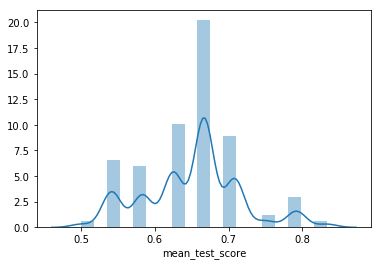

In [187]:
sns.distplot(results['mean_test_score'])
plt.show()

In [188]:
estimator.best_params_

{'clf__n_estimators': 10,
 'reduce_dim': None,
 'select_features__drt': 0.5,
 'select_features__group': True,
 'select_features__npeaks': 0.5}

In [189]:
estimator.best_score_

0.83333333333333337

In [153]:
X

,0,1,2,3,4,5,6,7,8,9,...,10936,10937,10938,10939,10940,10941,10942,10943,10944,10945
new_index,,,,,,,,,,,,,,,,,,,,,
20120829_07,4482.31,407.027,3671.02,6326.44,6176.96,533.566,18457.1,4475.88,1412.48,727.531,...,79918,5125.63,11959.2,25885,7409.45,6441.98,2778.57,2722.8,1438.29,425.79
20120829_08,2507.02,51.2232,3250.53,6517.23,4384.86,517.621,10634.7,6011.26,850.188,1016.01,...,123186,1565.6,11029.4,41771.9,7158.11,8263.18,2517.06,2331.97,2453.68,958.29
20120829_09,3298.28,4.20738,7994.55,9881.68,5931.93,483.42,14689.4,4546.74,874.314,942.373,...,75956.7,2721.17,10441.5,25155.9,6911.77,6635.63,2369.77,1620.75,2590.32,1443.06
20120829_100,1754.61,262.214,1704.33,7109.08,3797.1,439.296,8886.16,5029.88,456.016,1324.18,...,20406.6,489.11,274.326,6152.39,126.473,1370.22,55.4646,95.7112,146.4,48.0095
20120829_101,1495.63,111.67,1964.83,6670.93,5255.66,285.331,8409.28,4028.25,342.784,1015.89,...,16385.9,69.7487,380.941,4010.65,117.559,901.018,69.905,58.6354,246.885,102.901
20120829_102,3020.06,157.998,1634.87,7136.84,5181.62,408.465,12003.4,5873.79,367.427,979.468,...,21281.1,132.173,387.814,5939.97,172.314,1177.66,41.3523,133.906,78.639,54.9892
20120829_103,2481.63,63.1608,1228.99,7284.39,5255.64,383.222,11254.2,5130.25,407.389,1640.23,...,4637.41,42.7096,269.473,880.128,178.026,185.109,34.4602,73.4292,121.923,17.7994
20120829_104,2558.77,105.553,1993.79,7162.73,6179.08,339.455,10711.1,5374.43,663.869,894.002,...,7253.53,112.544,287.321,2015.75,153.179,414.203,95.5041,47.2978,73.6355,75.7553
20120829_105,2993.82,183.156,1004.28,7331.51,5880.73,423.792,12874.4,4714.81,845.356,797.323,...,197.192,47.4063,430.275,59.1959,105.233,13.4843,36.1623,76.7565,105.527,18.0521


In [190]:
results.to_csv("RANDFOREST_S266_1.csv")

In [191]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(np.log10(X.fillna(1).replace(0,1)))

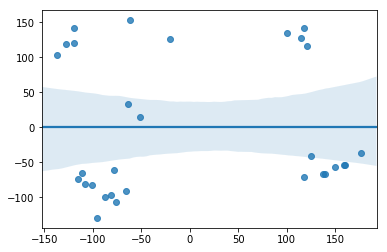

In [47]:
sns.regplot(x=X_pca[:,0],y = X_pca[:,1])
plt.show()

In [192]:
X_pca_df = pd.DataFrame(X_pca, columns=['x','y'])
X_pca_df['hue'] = y

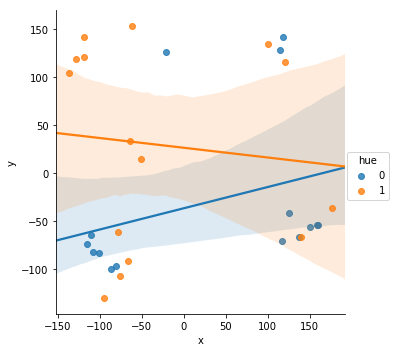

In [193]:
sns.lmplot(x='x', y='y', hue = 'hue', data = X_pca_df)
plt.show()

In [130]:
pca.explained_variance_ratio_

array([ 0.40346743,  0.20560745])